In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(color_codes = True)

In [3]:
df = pd.read_csv('storage.csv')
df

,timestamp,directory,current_space_gb,growth_rate_gb_per_day,deletion_rate_gb_per_day,net_change_gb_per_day
0,2025-02-25,/dir_A,425.15,7.74,0.59,7.15
1,2025-02-26,/dir_A,426.06,2.33,1.42,0.91
2,2025-02-27,/dir_A,430.15,4.51,0.43,4.09
3,2025-02-28,/dir_A,432.91,2.77,0.00,2.76
4,2025-03-01,/dir_A,438.91,9.31,3.31,6.00
...,...,...,...,...,...,...
145,2025-03-22,/dir_E,299.44,4.98,2.28,2.69
146,2025-03-23,/dir_E,302.58,3.33,0.19,3.14
147,2025-03-24,/dir_E,305.18,5.87,3.28,2.60
148,2025-03-25,/dir_E,308.88,9.41,5.71,3.71


Dataset Overview:
   timestamp directory  current_space_gb  growth_rate_gb_per_day  \
0 2025-02-25    /dir_A            425.15                    7.74   
1 2025-02-26    /dir_A            426.06                    2.33   
2 2025-02-27    /dir_A            430.15                    4.51   
3 2025-02-28    /dir_A            432.91                    2.77   
4 2025-03-01    /dir_A            438.91                    9.31   

   deletion_rate_gb_per_day  net_change_gb_per_day  
0                      0.59                   7.15  
1                      1.42                   0.91  
2                      0.43                   4.09  
3                      0.00                   2.76  
4                      3.31                   6.00  

Summary Statistics:
                 timestamp  current_space_gb  growth_rate_gb_per_day  \
count                  150        150.000000              150.000000   
mean   2025-03-11 12:00:00        364.387067                5.511200   
min    2025-02-25 

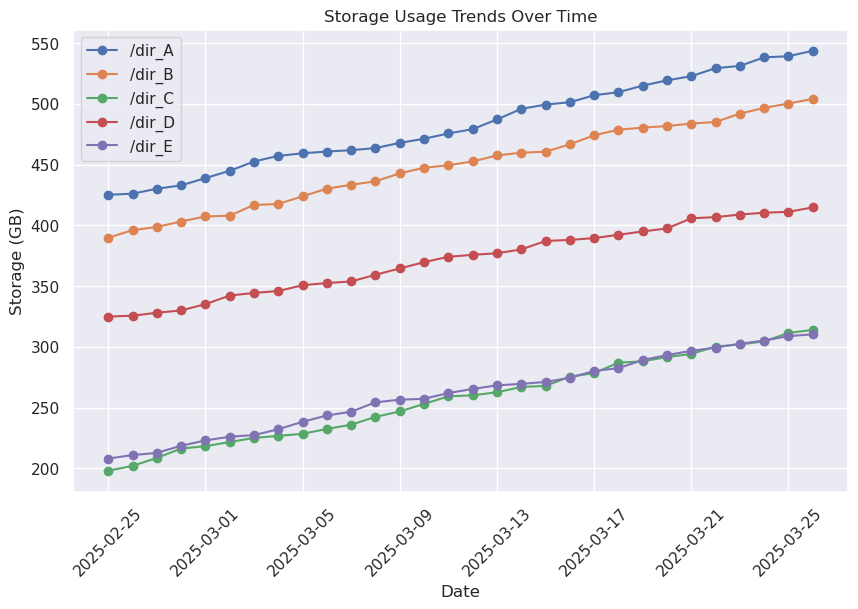

In [9]:
 #Convert timestamp to datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Summary statistics
print("Dataset Overview:")
print(df.head())  # Show first few rows
print("\nSummary Statistics:")
print(df.describe())  # Show basic statistics

# List unique directories
directories = df["directory"].unique()
print("\nDirectories in Dataset:", directories)

# Plot storage trends per directory
plt.figure(figsize=(10, 6))
for directory in directories:
    subset = df[df["directory"] == directory]
    plt.plot(subset["timestamp"], subset["current_space_gb"], marker="o", label=directory)

plt.xlabel("Date")
plt.ylabel("Storage (GB)")
plt.title("Storage Usage Trends Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [11]:
df = df.sort_values("timestamp")

In [16]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

2025-03-07 10:21:16.802889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 10:21:17.060135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Normalize the storage data
scaler = MinMaxScaler()
df["normalized_space"] = scaler.fit_transform(df[["current_space_gb"]])


In [24]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [26]:
# Define sequence length (past days used for prediction)
sequence_length = 10  
storage_data = df["normalized_space"].values

In [28]:
X, y = create_sequences(storage_data, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input


In [30]:
# Train-test split (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


In [32]:
# Build LSTM model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Train model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2668 - val_loss: 0.3687
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2406 - val_loss: 0.2800
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1541 - val_loss: 0.1514
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1024 - val_loss: 0.0940
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0840 - val_loss: 0.0814
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0763 - val_loss: 0.0969
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0800 - val_loss: 0.0887
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0787 - val_loss: 0.0813
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0753 - val_loss: 0.0816
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0728 - val_loss: 0.0819
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0759 - val_loss: 0.0853
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0694 - val_loss: 0.0827
Epoch 13/20


In [38]:
# Predict future storage (for next 1 week & 1 month)
def predict_future(storage_data, days):
    future_predictions = []
    input_seq = storage_data[-sequence_length:].reshape(1, sequence_length, 1)  # Take last sequence
    for _ in range(days):
        next_prediction = model.predict(input_seq)[0][0]
        future_predictions.append(next_prediction)
        input_seq = np.roll(input_seq, -1)  # Shift sequence
        input_seq[0, -1, 0] = next_prediction  # Add new prediction
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


In [40]:
# Predict for each directory
directories = df["directory"].unique()
predictions_1w = {}
predictions_1m = {}

In [42]:
for directory in directories:
    subset = df[df["directory"] == directory]["normalized_space"].values
    pred_1w = predict_future(subset, 7).sum()  # Sum total predicted storage for 1 week
    pred_1m = predict_future(subset, 30).sum()  # Sum total predicted storage for 1 month
    predictions_1w[directory] = pred_1w
    predictions_1m[directory] = pred_1m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━

In [46]:
# Plot Pie Charts
def plot_pie_chart(data, title):
    labels = list(data.keys())
    sizes = list(data.values())
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.show()

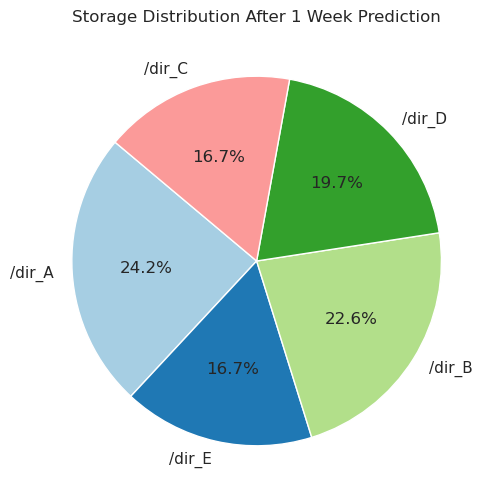

In [48]:
# Pie chart for 1-week prediction
plot_pie_chart(predictions_1w, "Storage Distribution After 1 Week Prediction")


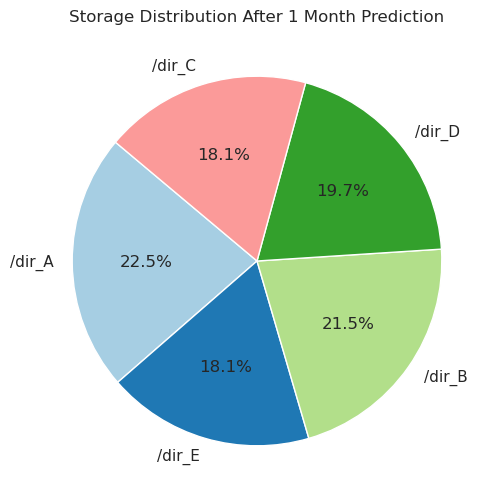

In [50]:
# Pie chart for 1-month prediction
plot_pie_chart(predictions_1m, "Storage Distribution After 1 Month Prediction")